Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10629
           1       0.79      0.41      0.54      1167

    accuracy                           0.93     11796
   macro avg       0.86      0.70      0.75     11796
weighted avg       0.92      0.93      0.92     11796

Accuracy: 0.9304001356391998
AUC-ROC: 0.9002605843917181
Confusion Matrix:
 [[10502   127]
 [  694   473]]


Model: Random Forest
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10629
           1       0.86      0.48      0.61      1167

    accuracy                           0.94     11796
   macro avg       0.90      0.73      0.79     11796
weighted avg       0.94      0.94      0.93     11796

Accuracy: 0.9404035266191929
AUC-ROC: 0.9227570397813035
Confusion Matrix:
 [[10536    93]
 [  610   557]]




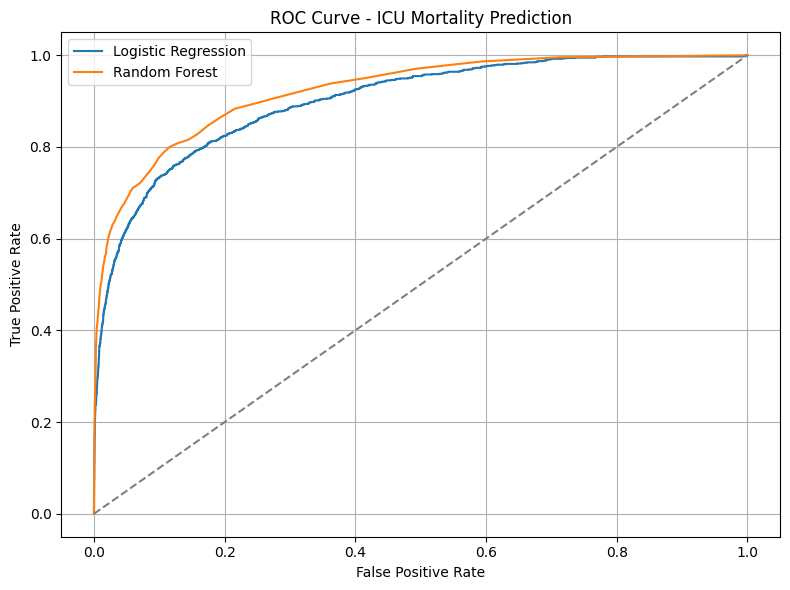

In [1]:
# -----------------------------------
# ICU Mortality Prediction Pipeline
# -----------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
)

# -------------------------------
# Step 1: Load Dataset
# -------------------------------
df = pd.read_csv('mimic3c.csv')  # Make sure your file is in the same directory

# -------------------------------
# Step 2: Feature Engineering
# -------------------------------

# Create derived features
df['interactions_per_day'] = df['TotalNumInteract'] / (df['LOSdays'] + 1)
df['lab_rx_ratio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['proc_diag_ratio'] = df['NumProcs'] / (df['NumDiagnosis'] + 1)
df['chart_density'] = df['NumChartEvents'] / (df['LOSdays'] + 1)

# Complexity proxy: number of services touched
df['total_unique_events'] = (
    (df['NumLabs'] > 0).astype(int) +
    (df['NumMicroLabs'] > 0).astype(int) +
    (df['NumRx'] > 0).astype(int) +
    (df['NumNotes'] > 0).astype(int) +
    (df['NumProcEvents'] > 0).astype(int) +
    (df['NumChartEvents'] > 0).astype(int)
)

# High-intensity case flag
df['high_intensity_flag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Target variable
df['expired'] = df['ExpiredHospital'].astype(int)

# -------------------------------
# Step 3: Encode Categorical Variables
# -------------------------------
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance',
                    'religion', 'marital_status', 'ethnicity']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# -------------------------------
# Step 4: Drop Unused Columns
# -------------------------------
drop_cols = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
df.drop(columns=drop_cols, inplace=True)

# -------------------------------
# Step 5: Normalize Skewed Features
# -------------------------------
skewed_cols = ['TotalNumInteract', 'interactions_per_day', 'NumChartEvents', 'NumRx']
log_transformer = FunctionTransformer(np.log1p)
df[skewed_cols] = log_transformer.fit_transform(df[skewed_cols])

# Optional: Standardize numerical features
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('expired')

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# -------------------------------
# Step 6: Train-Test Split
# -------------------------------
X = df.drop(columns=['expired'])
y = df['expired']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Step 7: Modeling
# -------------------------------

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# -------------------------------
# Step 8: Evaluation
# -------------------------------

def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"Model: {name}")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("AUC-ROC:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n")

evaluate_model("Logistic Regression", y_test, y_pred_log, y_proba_log)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)

# -------------------------------
# Step 9: ROC Curve Plot
# -------------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ICU Mortality Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Full updated pipeline with all preprocessing, feature engineering, EDA, modeling, evaluation, and visualization steps

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score
)

# -----------------------------------
# Step 1: Load Dataset
# -----------------------------------
df = pd.read_csv('mimic3c.csv')
print("Initial dataset shape:", df.shape)

# -----------------------------------
# Step 2: Initial Feature Engineering
# -----------------------------------

# Total number of interactions
df['total_interactions'] = (
    df['count_lab'] +
    df['count_micro'] +
    df['count_note'] +
    df['count_proc'] +
    df['count_med'] +
    df['count_caregiver'] +
    df['count_imaging']
)

# Lab to Medication ratio
df['lab_med_ratio'] = df['count_lab'] / (df['count_med'] + 1)

# Average daily interactions
df['avg_daily_interactions'] = df['total_interactions'] / (df['count_charttime_days'] + 1)

# Additional derived features
df['interactions_per_day'] = df['TotalNumInteract'] / (df['LOSdays'] + 1)
df['lab_rx_ratio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['proc_diag_ratio'] = df['NumProcs'] / (df['NumDiagnosis'] + 1)
df['chart_density'] = df['NumChartEvents'] / (df['LOSdays'] + 1)

df['total_unique_events'] = (
    (df['NumLabs'] > 0).astype(int) +
    (df['NumMicroLabs'] > 0).astype(int) +
    (df['NumRx'] > 0).astype(int) +
    (df['NumNotes'] > 0).astype(int) +
    (df['NumProcEvents'] > 0).astype(int) +
    (df['NumChartEvents'] > 0).astype(int)
)

df['high_intensity_flag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Target variable
df['expired'] = df['ExpiredHospital'].astype(int)

# -----------------------------------
# Step 3: Exploratory Data Analysis
# -----------------------------------
missing = df.isnull().sum().sort_values(ascending=False).head(10)
describe = df.describe().T

# Target distribution
sns.countplot(x=df['expired'])
plt.title('Distribution of Expired (0 = Alive, 1 = Expired)')
plt.show()

# Feature histograms
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols].hist(bins=20, figsize=(16, 12), layout=(6, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

# -----------------------------------
# Step 4: Categorical Encoding
# -----------------------------------
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# -----------------------------------
# Step 5: Drop Unused Columns
# -----------------------------------
drop_cols = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
df.drop(columns=drop_cols, inplace=True)

# -----------------------------------
# Step 6: Feature Transformation
# -----------------------------------
skewed_cols = ['TotalNumInteract', 'interactions_per_day', 'NumChartEvents', 'NumRx']
log_transformer = FunctionTransformer(np.log1p)
df[skewed_cols] = log_transformer.fit_transform(df[skewed_cols])

# Standardize numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('expired')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# -----------------------------------
# Step 7: Train-Test Split
# -----------------------------------
X = df.drop(columns=['expired'])
y = df['expired']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# -----------------------------------
# Step 8: Modeling
# -----------------------------------
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# -----------------------------------
# Step 9: Evaluation
# -----------------------------------
print("📊 Logistic Regression Performance:\n")
print(classification_report(y_test, y_pred_log))
print("AUC:", roc_auc_score(y_test, y_proba_log))

print("\n📊 Random Forest Performance:\n")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_proba_rf))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest", linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importances
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10, 8), color='teal')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Outputs for report
missing, describe.head()



Initial dataset shape: (58976, 28)


KeyError: 'count_lab'

In [4]:
# --- Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

# --- Load Data ---
df = pd.read_csv('mimic3c.csv')
print("Initial dataset shape:", df.shape)

# --- Feature Engineering ---
df['total_interactions'] = (
    df['count_lab'] + df['count_micro'] + df['count_note'] +
    df['count_proc'] + df['count_med'] + df['count_caregiver'] +
    df['count_imaging']
)
df['lab_med_ratio'] = df['count_lab'] / (df['count_med'] + 1)
df['avg_daily_interactions'] = df['total_interactions'] / (df['count_charttime_days'] + 1)
df['interactions_per_day'] = df['TotalNumInteract'] / (df['LOSdays'] + 1)
df['lab_rx_ratio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['proc_diag_ratio'] = df['NumProcs'] / (df['NumDiagnosis'] + 1)
df['chart_density'] = df['NumChartEvents'] / (df['LOSdays'] + 1)
df['total_unique_events'] = (
    (df['NumLabs'] > 0).astype(int) + (df['NumMicroLabs'] > 0).astype(int) +
    (df['NumRx'] > 0).astype(int) + (df['NumNotes'] > 0).astype(int) +
    (df['NumProcEvents'] > 0).astype(int) + (df['NumChartEvents'] > 0).astype(int)
)
df['high_intensity_flag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)
df['expired'] = df['ExpiredHospital'].astype(int)

# --- Categorical Encoding ---
cat_cols = ['gender', 'admit_type', 'admit_location', 'insurance',
            'religion', 'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- Drop Non-informative Columns ---
df.drop(columns=['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital'], inplace=True)

# --- Log Transform Skewed Features ---
skewed_cols = ['TotalNumInteract', 'interactions_per_day', 'NumChartEvents', 'NumRx']
df[skewed_cols] = FunctionTransformer(np.log1p).fit_transform(df[skewed_cols])

# --- Normalize Numerical Features ---
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('expired')
df[num_cols] = StandardScaler().fit_transform(df[num_cols])

# --- Train/Test Split ---
X = df.drop(columns=['expired'])
y = df['expired']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Logistic Regression ---
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# --- Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# --- Evaluation ---
print("📊 Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("AUC:", roc_auc_score(y_test, y_proba_log))

print("\n📊 Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_proba_rf))

# --- Confusion Matrix ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest", linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# --- Feature Importance (Random Forest) ---
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10, 8), color='teal')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


Initial dataset shape: (58976, 28)


KeyError: 'count_lab'